# Разметка активных областей на основе данных КРАО
Пример выделения фрагментов активных областей с полного диска HMI магнитограмм
Описание подходов к выделению фрагментов здесь:
readme http://crao.ru/images/sun/catalog/Readme.txt


http://jn.craocrimea.ru/index.php/izvcrao/article/view/643/598

In [6]:
import numpy as np 
import os
import pandas as pd 
import time
import datetime
import drms
import urllib
from astropy.time import Time
from datetime import timedelta
import json
import urllib, requests
import matplotlib.pyplot as plt
from astropy.io import fits
from sunpy.coordinates import frames
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [18]:
DOWNLOAD = False
SAVE_PATH = 'dataset'
if DOWNLOAD:
    df = pd.read_csv('http://crao.ru/images/sun/catalog/Catalog_2010_2017.txt', delim_whitespace=True, header=None)
    colnames = ['Year', 'Month','Day','Hour', 'Minutes','Sec','YD','HARP','NOAA','ABSFLUX',\
             'Hale','Joy','Leader','Cat','BoxNum','minLat','maxLat','minLon','maxLon','ldBox','luBox','ruBox','rdBox']
    df.columns = colnames
    df.to_pickle(os.path.join(SAVE_PATH,'ManualBoxes.pkl'))
    
else:
    df = pd.read_pickle('ManualBoxes.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 23 columns):
Year       1679 non-null int64
Month      1679 non-null int64
Day        1679 non-null int64
Hour       1679 non-null int64
Minutes    1679 non-null int64
Sec        1679 non-null int64
YD         1679 non-null float64
HARP       1679 non-null int64
NOAA       1679 non-null int64
ABSFLUX    1679 non-null float64
Hale       1679 non-null object
Joy        1679 non-null object
Leader     1679 non-null object
Cat        1679 non-null object
BoxNum     1679 non-null int64
minLat     1679 non-null float64
maxLat     1679 non-null float64
minLon     1679 non-null float64
maxLon     1679 non-null float64
ldBox      1679 non-null int64
luBox      1679 non-null int64
ruBox      1679 non-null int64
rdBox      1679 non-null int64
dtypes: float64(6), int64(13), object(4)
memory usage: 301.8+ KB


In [19]:
df['Datetime']=pd.to_datetime(df.loc[:,'Year':'Minutes'])
df.head()

,Year,Month,Day,Hour,Minutes,Sec,YD,HARP,NOAA,ABSFLUX,...,BoxNum,minLat,maxLat,minLon,maxLon,ldBox,luBox,ruBox,rdBox,Datetime
0,2010,6,7,5,24,0,2455354.7,45,11073,3.002851e+21,...,0,18.625023,21.290476,62.566246,68.014717,0,0,0,0,2010-06-07 05:24:00
1,2010,6,16,5,24,0,2455363.7,57,11082,6.256493e+21,...,1,27.039186,30.557147,-60.185622,-56.481470,145,10,342,328,2010-06-16 05:24:00
2,2010,6,25,5,24,0,2455372.7,66,0,3.798848e+21,...,1,12.419511,17.130973,-45.787434,-37.734310,68,5,304,206,2010-06-25 05:24:00
3,2010,6,25,5,24,0,2455372.7,68,0,1.216575e+21,...,0,17.004215,19.917381,31.605930,36.647469,0,0,0,0,2010-06-25 05:24:00
4,2010,6,25,5,24,0,2455372.7,67,11085,1.157716e+21,...,1,-23.817796,-21.509239,-41.908884,-39.426002,50,78,161,130,2010-06-25 05:24:00


Общее количество размеченных магнитограмм 308
Распределение по количеству фрагментов на диске


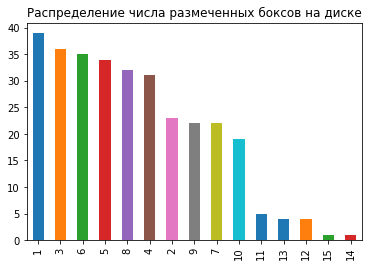

In [14]:
df_MagnList = df.groupby('Datetime')['BoxNum'].count()
print(f'Общее количество размеченных магнитограмм {df_MagnList.shape[0]}')
print('Распределение по количеству фрагментов на диске')
df_MagnList.value_counts().plot(kind='bar', title='Распределение числа размеченных боксов на диске')

In [16]:
print('Посмотрим в какой момент была самая богатая на боксы магнитограмма\n')
df_MagnList.loc[df_MagnList==15]

Посмотрим в какой момент была самая богатая на боксы магнитограмма



Datetime
2014-05-17 05:24:00    15
Name: BoxNum, dtype: int64

## Загрузка и разметка магнитограммы
Возьмем самую жирную, посмотрим на нее и разметим. Это было 2014-05-17 05:24:00

In [17]:
df.loc[df['Datetime']==pd.datetime(2014,5,17,5,24)].drop(['Year','Month','Day','Hour','Minutes','Sec','YD'],axis=1)

,HARP,NOAA,ABSFLUX,Hale,Joy,Leader,Cat,BoxNum,minLat,maxLat,minLon,maxLon,ldBox,luBox,ruBox,rdBox,Datetime
1035,2606,0,5.026810e+21,Y,N,0,B,0,-18.563648,-10.793083,-3.345712,6.253107,0,0,0,0,2014-05-17 05:24:00
1036,2619,0,3.488252e+20,N,0,0,U,0,-16.057398,-14.566745,-28.316641,-25.485590,0,0,0,0,2014-05-17 05:24:00
1037,2623,0,4.320035e+20,N,0,0,U,0,18.505817,19.988085,-33.126896,-30.316051,0,0,0,0,2014-05-17 05:24:00
1038,2572,12055,3.207568e+22,Y,0,0,U,2,10.230253,14.208938,76.177191,79.760460,1192,398,151,164,2014-05-17 05:24:00
1039,2572,12056,7.916740e+21,Y,0,0,U,3,2.078801,5.911924,68.085177,71.882018,851,62,160,158,2014-05-17 05:24:00
1040,2572,12056,1.851853e+22,N,N,N,B,4,2.418445,9.890609,58.355775,68.441130,441,76,425,308,2014-05-17 05:24:00
1041,2572,12057,3.863059e+21,Y,0,0,U,1,12.898883,17.192952,55.508146,59.352446,321,508,162,177,2014-05-17 05:24:00
1042,2586,12060,2.392551e+22,Y,Y,Y,A,1,-23.711708,-9.809337,19.019278,37.453317,137,32,678,517,2014-05-17 05:24:00
1043,2598,12061,7.244137e+21,Y,Y,Y,A,1,-28.893412,-22.595625,-9.291602,0.159563,152,43,319,228,2014-05-17 05:24:00
1044,2608,12063,8.898539e+21,Y,Y,Y,A,0,6.908615,13.890449,-20.911133,-7.896848,0,0,0,0,2014-05-17 05:24:00


## Загрузка с JSOC магнитограммы с header
Загрузку делала  с помощью пакета [drms](http://docs.sunpy.org/projects/drms/en/stable/tutorial.html). Можно вроде и средствами sunpy, может быть полезен тьюториал:
https://github.com/sunpy/tutorial-notebooks/blob/master/2018-11-01_SunPyTutorial_SDO2018Ghent.ipynb

In [22]:
DOWNLOAD = False
EMAIL = 'iknyazeva@gmail.com'
SAVE_PATH = 'dataset'
if DOWNLOAD:
    c = drms.Client(email=EMAIL, verbose=True)
    moment= pd.datetime(2014,5,17,5,24)
    str_for_query = 'hmi.m_720s'+ moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI]{magnetogram}')
    #ds = f'hmi.sharp_720s[{4864}][2014.11.30_00:00_TAI]{continuum, magnetogram}'
    print(str_for_query)
    r = c.export(str_for_query, method='url', protocol='fits')
    print(r)
    r.wait()
    print(r.request_url)
    filename ='hmi.sharp_720s.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.magnetogram.fits')
    filepath=os.path.join(SAVE_PATH,filename)

    print("Download data and save to path", filepath)
    r.download(SAVE_PATH) 

In [29]:
#Читаем хедер
hdulist = fits.open('dataset/'+'hmi.m_720s.20140517_052400_TAI.1.magnetogram.fits')
hdulist[1].verify("silentfix")

In [30]:
hdulist[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4096 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
DATE    = '2014-05-23T03:52:24'                                                 
DATE-OBS= '2014-05-17T05:22:23.20'                                              
TELESCOP= 'SDO/HMI'                                                             
INSTRUME= 'HMI_SIDE1'                                                           
WAVELNTH= 6173.0            

In [31]:
hdulist.info()

Filename: dataset/hmi.m_720s.20140517_052400_TAI.1.magnetogram.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 CompImageHDU    105   (4096, 4096)   int32   


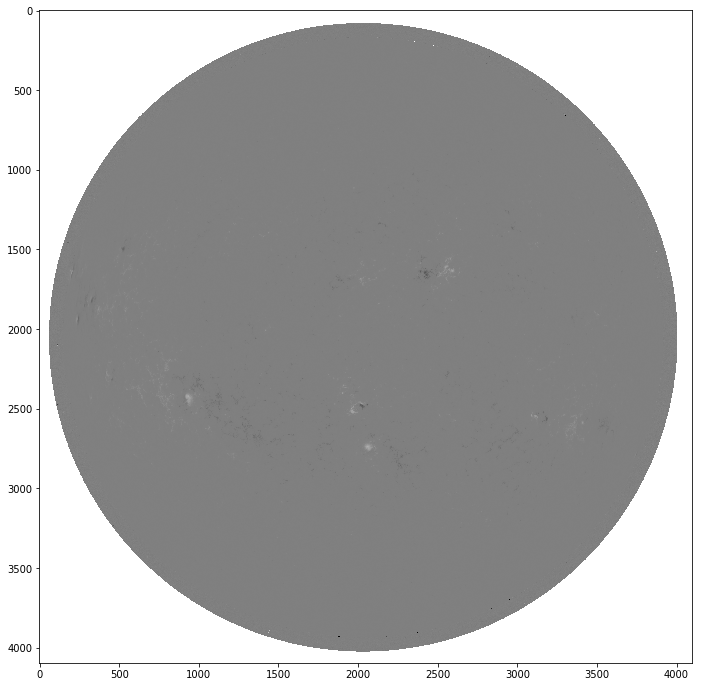

In [33]:
# нарисуем средствами matplotlib
data = hdulist[1].data
plt.figure(figsize  = [12,12])
plt.imshow(data, cmap = 'gray' )

In [37]:
file_url = 'https://solarmonitor.org/data/2014/05/17/pngs/shmi/shmi_maglc_fd_20140517_224623.png'

file_url.split(sep='/')[-1]

'shmi_maglc_fd_20140517_224623.png'

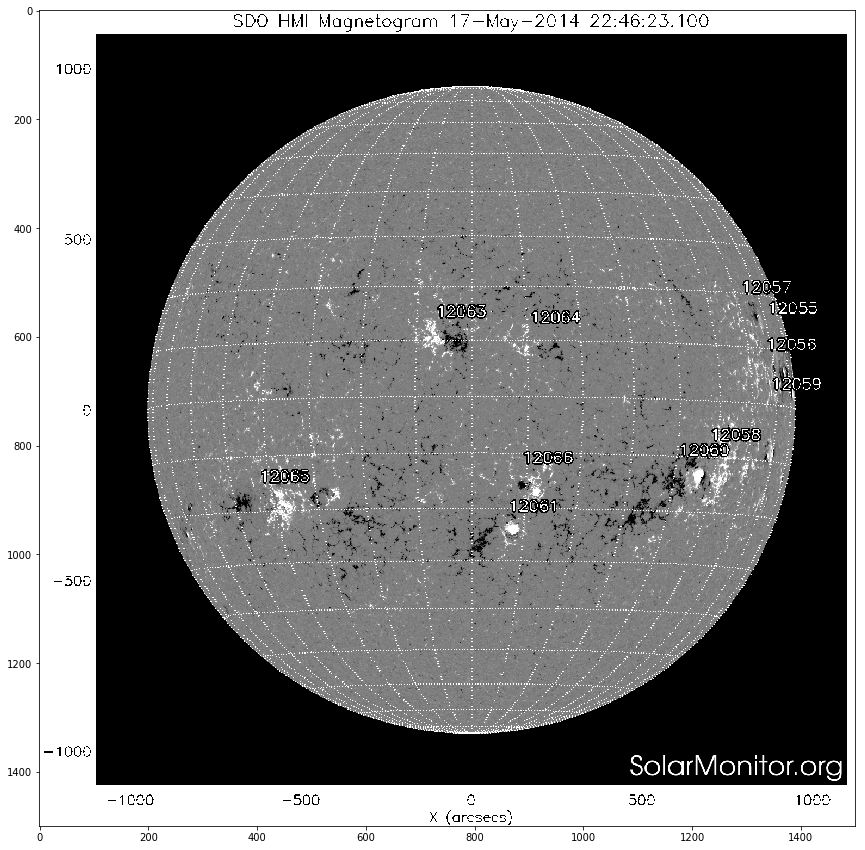

In [38]:
import matplotlib.image as mpimg

#посмотрим на размеченную картинку с solarmonitor
file_url = 'https://solarmonitor.org/data/2014/05/17/pngs/shmi/shmi_maglc_fd_20140517_224623.png'

if DOWNLOAD:
    import wget
    file_name = wget.download(file_url)
else:
    file_name = file_url.split(sep='/')[-1]
    img=mpimg.imread(os.path.join(SAVE_PATH, file_name))
plt.figure(figsize = (20,15))
imgplot = plt.imshow(img)

## Повозимся с координатами

In [40]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map

In [41]:
mymap = sunpy.map.Map(os.path.join(SAVE_PATH,'hmi.m_720s.20140517_052400_TAI.1.magnetogram.fits'))

In [95]:
#inds = np.where(np.isnan(mymap.data))
#mymap.data[inds[0],inds[1]] = 9999
#mask = (mymap.data == 9999) or (mymap.data < 500)
#mymap.mask = mask

## Почему переворачиваются координаты???? 

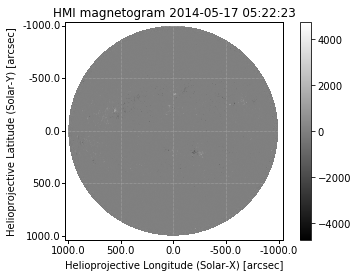

In [45]:
mymap.peek()

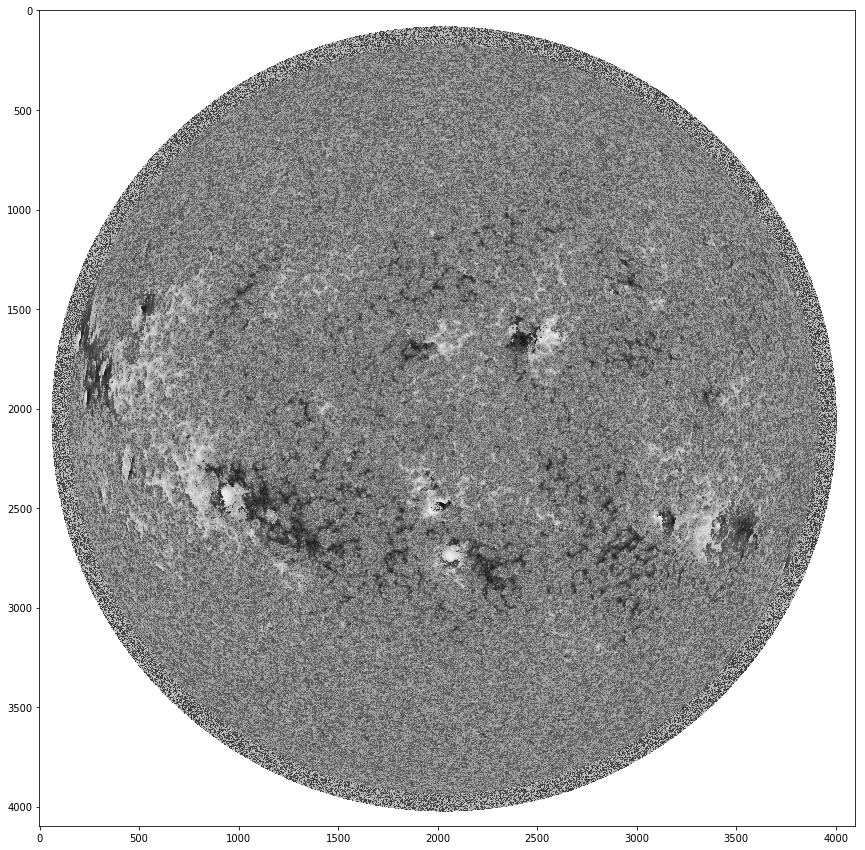

In [138]:
# Ничего не видно, потому что большие поля в областях, в solar monitor ось x развернута 
plt.figure(figsize = (20,15))
data = np.sign(mymap.data)*np.log1p(np.abs(mymap.data))
#mymap.peek()
plt.imshow(data, cmap = 'gray' )

In [46]:
print(mymap.coordinate_frame)

<Helioprojective Frame (obstime=2014-05-17 05:22:23.200000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2014-05-17 05:22:23.200000): (lon, lat, radius) in (deg, deg, m)
    (0., -2.430632, 1.51303886e+11)>)>


## Выделяем нужные нам боксы
В табличке координаты даны  в HeliographicStonyhurst, а фитсы в Helioprojective. Нужно перевести из одной системы в другую. Проще всего сделать с помощью wcs

In [49]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'Sec', 'YD', 'HARP', 'NOAA',
       'ABSFLUX', 'Hale', 'Joy', 'Leader', 'Cat', 'BoxNum', 'minLat', 'maxLat',
       'minLon', 'maxLon', 'ldBox', 'luBox', 'ruBox', 'rdBox', 'Datetime'],
      dtype='object')

In [54]:
df.loc[df['Datetime']==pd.datetime(2014,5,17,5,24)][['Datetime','NOAA','HARP','minLat','maxLat','minLon','maxLon']]

,Datetime,NOAA,HARP,minLat,maxLat,minLon,maxLon
1035,2014-05-17 05:24:00,0,2606,-18.563648,-10.793083,-3.345712,6.253107
1036,2014-05-17 05:24:00,0,2619,-16.057398,-14.566745,-28.316641,-25.485590
1037,2014-05-17 05:24:00,0,2623,18.505817,19.988085,-33.126896,-30.316051
1038,2014-05-17 05:24:00,12055,2572,10.230253,14.208938,76.177191,79.760460
1039,2014-05-17 05:24:00,12056,2572,2.078801,5.911924,68.085177,71.882018
1040,2014-05-17 05:24:00,12056,2572,2.418445,9.890609,58.355775,68.441130
1041,2014-05-17 05:24:00,12057,2572,12.898883,17.192952,55.508146,59.352446
1042,2014-05-17 05:24:00,12060,2586,-23.711708,-9.809337,19.019278,37.453317
1043,2014-05-17 05:24:00,12061,2598,-28.893412,-22.595625,-9.291602,0.159563
1044,2014-05-17 05:24:00,12063,2608,6.908615,13.890449,-20.911133,-7.896848


## Посмотрим на боксы

In [60]:
import sunpy.wcs
def plot_b0x_by_id(index_,df=df,hdulist=hdulist):
    
    min_lon = df.minLon.iloc[index_]
    min_lat = df.minLat.iloc[index_]
    max_lon = df.maxLon.iloc[index_]
    max_lat = df.maxLat.iloc[index_]
    bl = sunpy.wcs.convert_hg_hpc(min_lon, min_lat,b0_deg=hdulist[1].header['CRLT_OBS'])
    tr = sunpy.wcs.convert_hg_hpc(max_lon, max_lat,b0_deg=hdulist[1].header['CRLT_OBS'])
    print(f'AR {df.NOAA.iloc[index_]} \n')
    print('Min Lon, min Lat:', bl)
    print('Max Lon, max Lat:', tr)
    bottom_left =SkyCoord(bl[0]*u.arcsec, bl[1]*u.arcsec, frame="helioprojective")
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame="helioprojective")
    my_submap = mymap.submap(bottom_left, top_right)
    my_submap.peek()

AR 0 

Min Lon, min Lat: (-53.29131742620583, -267.724592564685)
Max Lon, max Lat: (103.07455627938782, -140.34586372842548)


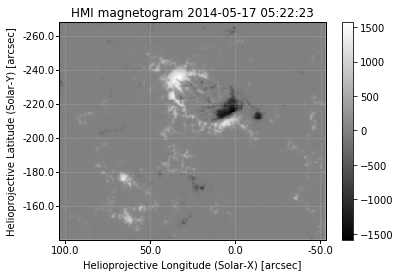

In [61]:
plot_b0x_by_id(1035)

AR 0 

Min Lon, min Lat: (-438.87913927062806, -231.5264615576851)
Max Lon, max Lat: (-401.00953386641277, -206.28451578770793)


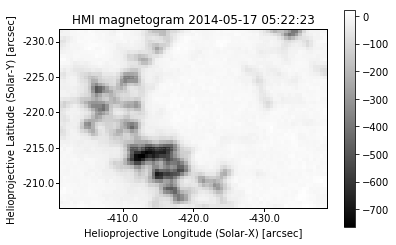

In [62]:
plot_b0x_by_id(1036)

AR 0 

Min Lon, min Lat: (-498.77752857578264, 337.62290808060084)
Max Lon, max Lat: (-456.5865980805185, 361.8334730662853)


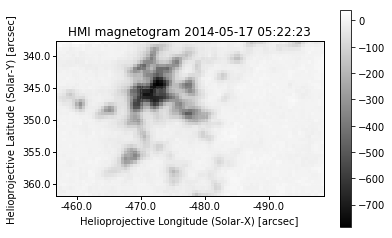

In [63]:
plot_b0x_by_id(1037)

AR 12055 

Min Lon, min Lat: (917.3503161565963, 179.91343425022058)
Max Lon, max Lat: (915.502022931435, 242.362108949188)


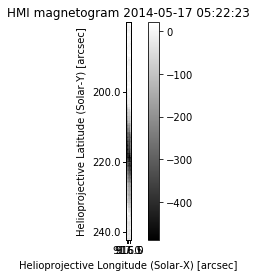

In [64]:
plot_b0x_by_id(1038)

AR 12056 

Min Lon, min Lat: (890.6136618836712, 50.008881441348414)
Max Lon, max Lat: (907.8485170020908, 111.42052933361332)


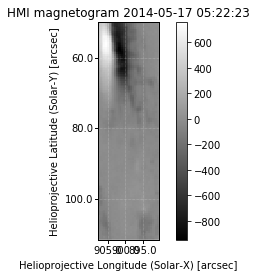

In [65]:
plot_b0x_by_id(1039)

AR 12056 

Min Lon, min Lat: (817.6390729860243, 61.896876313837836)
Max Lon, max Lat: (880.0636077575783, 179.5869749352275)


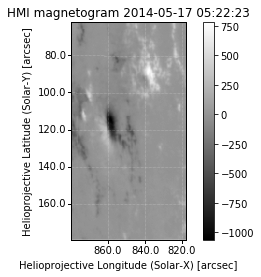

In [66]:
plot_b0x_by_id(1040)

AR 12057 

Min Lon, min Lat: (772.3816535115568, 236.92255842932624)
Max Lon, max Lat: (789.8851699649395, 303.6772237414363)


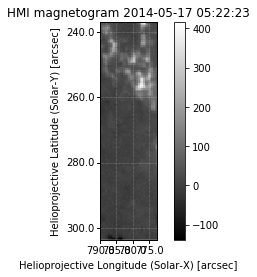

In [67]:
plot_b0x_by_id(1041)

AR 12060 

Min Lon, min Lat: (287.308452459395, -351.5226949750386)
Max Lon, max Lat: (576.7474091634184, -131.9013898617317)


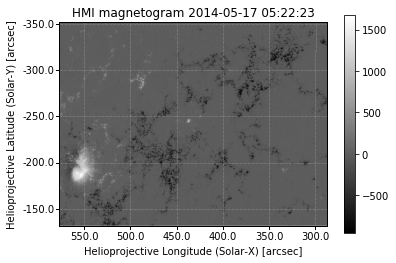

In [68]:
plot_b0x_by_id(1042)

AR 12061 

Min Lon, min Lat: (-136.11897420551227, -429.5610116426242)
Max Lon, max Lat: (2.4764257881776075, -332.02714809879166)


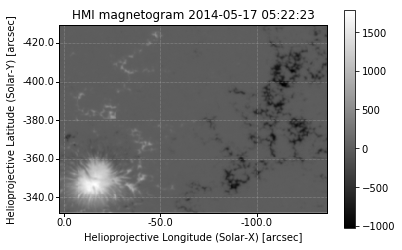

In [69]:
plot_b0x_by_id(1043)

AR 12063 

Min Lon, min Lat: (-341.2490043444054, 153.61889707731015)
Max Lon, max Lat: (-128.4667793966202, 270.3075356008193)


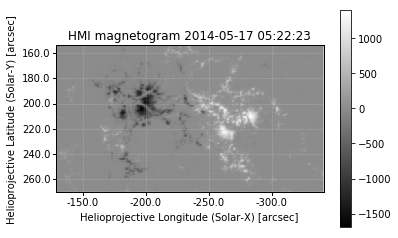

In [70]:
plot_b0x_by_id(1044)

AR 12064 

Min Lon, min Lat: (-52.51581845264891, 149.2219543227609)
Max Lon, max Lat: (121.13364706179108, 232.752025387673)


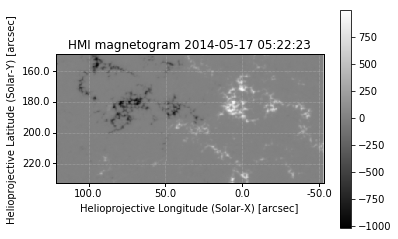

In [71]:
plot_b0x_by_id(1045)

AR 12065 

Min Lon, min Lat: (-771.4778668992166, -329.9641877595298)
Max Lon, max Lat: (-659.5688379810698, -230.42715590390955)


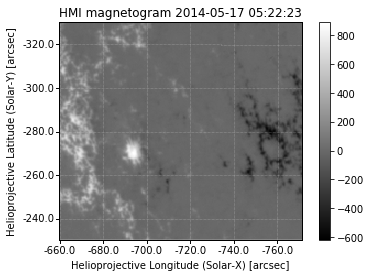

In [72]:
plot_b0x_by_id(1046)

AR 12066 

Min Lon, min Lat: (-26.53613675257719, -243.62188401250984)
Max Lon, max Lat: (40.84919904144419, -144.39052726255164)


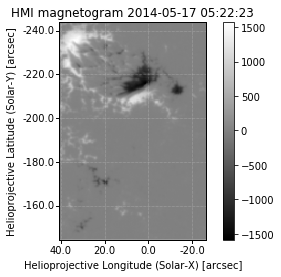

In [73]:
plot_b0x_by_id(1047)

AR 12067 

Min Lon, min Lat: (785.9508814875473, -148.62801480602826)
Max Lon, max Lat: (843.263832046359, -80.91399996853406)


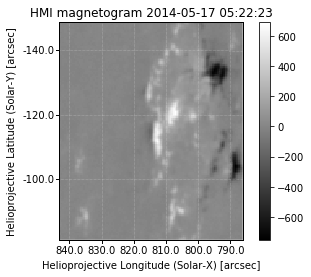

In [74]:
plot_b0x_by_id(1048)

AR 12068 

Min Lon, min Lat: (-599.2110069600353, -295.3743946296714)
Max Lon, max Lat: (-536.5179582414956, -228.55285126751727)


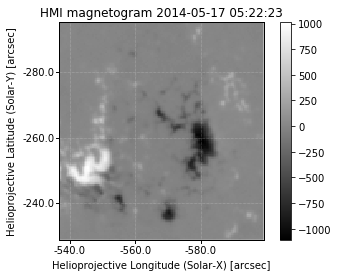

In [75]:
plot_b0x_by_id(1049)

In [17]:
c = SkyCoord(-21*u.deg, 6.9*u.deg, frame=frames.HeliographicStonyhurst)